In [73]:
using Plots, Statistics, NaNStatistics, LinearAlgebra, Serialization, ParticleFilters, StatsBase, Distributions

include("../utils/import.jl")
using .Import

include("../utils/figs.jl")
using .Figs

fig_directory = "../fig/"
filetype = ".png"
function save(name::String)
    savefig(fig_directory*name*filetype)
end

save (generic function with 1 method)

# SHORT runs

**Parameters:**\
steps: 100\
lookahead: 100\
runs: 25

_num items, arms, teachers: 3\
granularity of U and D: 3\
teacher betas: \[0.0, 0.01, 50.0\]\
state IDs: 1217, 1226, 1235, 1245, 4586, 4589, 4629, 4638, 4641, 1572, 1712, 3191, 3204, 3437, 3446, 3514, 3526, 3616, 4151, 4426_

**Algorithms:**\
ATS/active: select teachers and arms by solving POMDP\
passive: solve POMDP, but can't pick which teacher gets queried\
naive-X: act randomly for X steps, then always pull expected-best arm\
random: select teachers and arms randomly\
arms: pull arms randomly

**Variables:**\
discount: 0.9 (discounted) or 1.0 (undiscounted)\
horizon: finite or infinite\
rollout: random (all actions) or constrained (arm-only)

**Time:**\
active infinite: 45min\
passive infinite: 1h\
active finite: 2h\
passive finite: 3h\
random: 6m\
arms: 6m\
naive-25: 5m\
naive-50: 5m

In [74]:
# Experiment parameters
runs = 25
actions = ["C1", "C2", "C3", "B1", "B2", "B3", "B"]
afc, aic, pfc, pic = "active finite", "active infinite", "passive finite", "passive infinite"
r, ra, n25, n50 = "random", "random arms", "naive-25", "naive-50"

# Plotting Parameters
labels = [afc aic pfc pic r ra n25 n50]
discount = 0.999
window = 10
;

In [75]:
# Import experiments

# afc: active, finite, constrained
ids_afc = ["active_finite_2341_111423", "active_finite_2341_112136", "active_finite_2341_112818", "active_finite_2341_11353", "active_finite_2341_11421", "active_finite_2341_114924", "active_finite_2341_115420", "active_finite_2341_120135", "active_finite_2341_120830", "active_finite_2341_121329", "active_finite_2341_121822", "active_finite_2341_122520", "active_finite_2341_123155", "active_finite_2341_123657", "active_finite_2341_12420", "active_finite_2341_124914", "active_finite_2341_125547", "active_finite_2341_13031", "active_finite_2341_130942", "active_finite_2341_131639"]

# aic: active, infinite, constrained
ids_aic = ["active_infinite_2341_081552", "active_infinite_2341_08192", "active_infinite_2341_082154", "active_infinite_2341_082450", "active_infinite_2341_082741", "active_infinite_2341_083037", "active_infinite_2341_083323", "active_infinite_2341_083620", "active_infinite_2341_08397", "active_infinite_2341_084152", "active_infinite_2341_084432", "active_infinite_2341_084636", "active_infinite_2341_084937", "active_infinite_2341_085144", "active_infinite_2341_085434", "active_infinite_2341_085641", "active_infinite_2341_085849", "active_infinite_2341_090143", "active_infinite_2341_090348", "active_infinite_2341_090555"]

# pfc: passive, finite, constrained
ids_pfc = ["passive_finite_2341_133734", "passive_finite_2341_134420", "passive_finite_2341_135419", "passive_finite_2341_140418", "passive_finite_2341_141340", "passive_finite_2341_142112", "passive_finite_2341_143054", "passive_finite_2341_143723", "passive_finite_2341_14478", "passive_finite_2341_145331", "passive_finite_2341_15005", "passive_finite_2341_150918", "passive_finite_2341_151816", "passive_finite_2341_152817", "passive_finite_2341_153447", "passive_finite_2341_15442", "passive_finite_2341_155022", "passive_finite_2341_15590", "passive_finite_2341_16083", "passive_finite_2341_161435"]

# pic: passive, infinite, constrained
ids_pic = ["passive_infinite_2341_09546", "passive_infinite_2341_095718", "passive_infinite_2341_100046", "passive_infinite_2341_100348", "passive_infinite_2341_100725", "passive_infinite_2341_101050", "passive_infinite_2341_101342", "passive_infinite_2341_101638", "passive_infinite_2341_101858", "passive_infinite_2341_102143", "passive_infinite_2341_102442", "passive_infinite_2341_102740", "passive_infinite_2341_103059", "passive_infinite_2341_103410", "passive_infinite_2341_10377", "passive_infinite_2341_103953", "passive_infinite_2341_104218", "passive_infinite_2341_104429", "passive_infinite_2341_104659", "passive_infinite_2341_104957"]

# r: random
ids_r = ["random_2343_120826", "random_2343_120842", "random_2343_120859", "random_2343_120916", "random_2343_120932", "random_2343_120949", "random_2343_12106", "random_2343_121022", "random_2343_121039", "random_2343_121056", "random_2343_121112", "random_2343_121129", "random_2343_121146", "random_2343_12123", "random_2343_121219", "random_2343_121236", "random_2343_121252", "random_2343_12139", "random_2343_121326", "random_2343_121342"]

# ra: random arms
ids_ra = ["arms_2343_130315", "arms_2343_130331", "arms_2343_130348", "arms_2343_13044", "arms_2343_130420", "arms_2343_130436", "arms_2343_130452", "arms_2343_13058", "arms_2343_130524", "arms_2343_130540", "arms_2343_130556", "arms_2343_130612", "arms_2343_130629", "arms_2343_130646", "arms_2343_13073", "arms_2343_130720", "arms_2343_130736", "arms_2343_130753", "arms_2343_13089", "arms_2343_130826"]

# n25: naive with explore_timesteps = 25
ids_n25 = ["naive_25_2347_115430", "naive_25_2347_115445", "naive_25_2347_11550", "naive_25_2347_115515", "naive_25_2347_115530", "naive_25_2347_115545", "naive_25_2347_115559", "naive_25_2347_115614", "naive_25_2347_115629", "naive_25_2347_115643", "naive_25_2347_115658", "naive_25_2347_115713", "naive_25_2347_115727", "naive_25_2347_115742", "naive_25_2347_115756", "naive_25_2347_115811", "naive_25_2347_115825", "naive_25_2347_115840", "naive_25_2347_115854", "naive_25_2347_11599"]

# n50: naive with explore_timesteps = 50
ids_n50 = ["naive_50_2347_120424", "naive_50_2347_120438", "naive_50_2347_120452", "naive_50_2347_12057", "naive_50_2347_120521", "naive_50_2347_120535", "naive_50_2347_120549", "naive_50_2347_12064", "naive_50_2347_120618", "naive_50_2347_120633", "naive_50_2347_120647", "naive_50_2347_12071", "naive_50_2347_120715", "naive_50_2347_120730", "naive_50_2347_120744", "naive_50_2347_120758", "naive_50_2347_120813", "naive_50_2347_120827", "naive_50_2347_120841", "naive_50_2347_120855"]

s_afc, t_afc, a_afc, r_afc = Import.import_IDs(ids_afc, runs, directory="..")
s_aic, t_aic, a_aic, r_aic = Import.import_IDs(ids_aic, runs, directory="..")
s_pfc, t_pfc, a_pfc, r_pfc = Import.import_IDs(ids_pfc, runs, directory="..")
s_pic, t_pic, a_pic, r_pic = Import.import_IDs(ids_pic, runs, directory="..")
s_r, t_r, a_r, r_r = Import.import_IDs(ids_r, runs, directory="..")
s_ra, t_ra, a_ra, r_ra = Import.import_IDs(ids_ra, runs, directory="..")
s_n25, t_n25, a_n25, r_n25 = Import.import_IDs(ids_n25, runs, directory="..")
s_n50, t_n50, a_n50, r_n50 = Import.import_IDs(ids_n50, runs, directory="..")
;

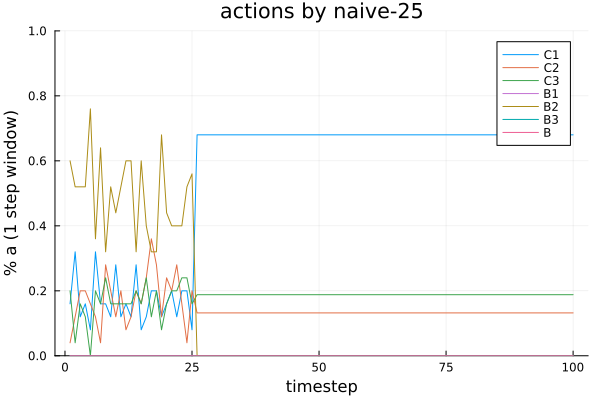

In [77]:
alg = n25
act = a_n25
Figs.plot_proportion_actions_all(act, actions, 1, "actions by "*alg)

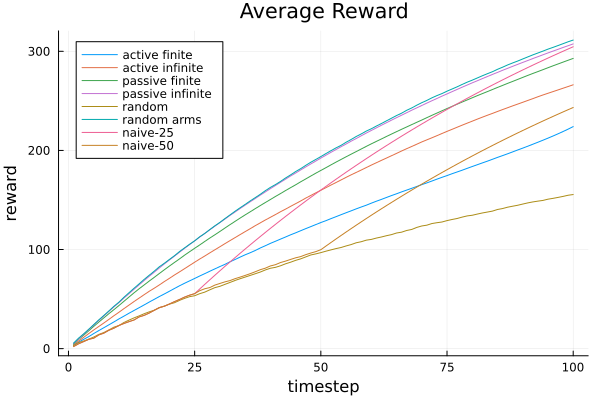

In [85]:
Figs.plot_cumulative_avg_r_multiple_experiments([r_afc, r_aic, r_pfc, r_pic, r_r, r_ra, r_n25, r_n50], .99, labels, "Average Reward")

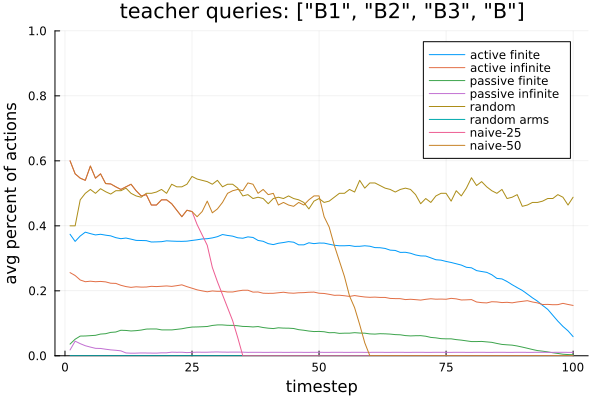

In [79]:
Figs.plot_actions_in_list_rolling_multiple_experiments([a_afc, a_aic, a_pfc, a_pic, a_r, a_ra, a_n25, a_n50], ["B1", "B2", "B3", "B"], window, labels, "teacher queries: ")

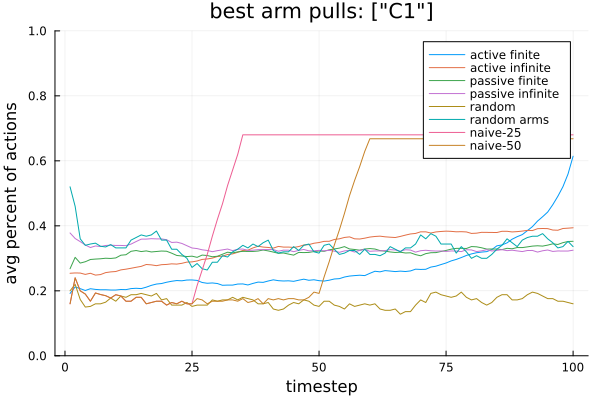

In [80]:
Figs.plot_actions_in_list_rolling_multiple_experiments([a_afc, a_aic, a_pfc, a_pic, a_r, a_ra, a_n25, a_n50], ["C1"], window, labels, "best arm pulls: ")

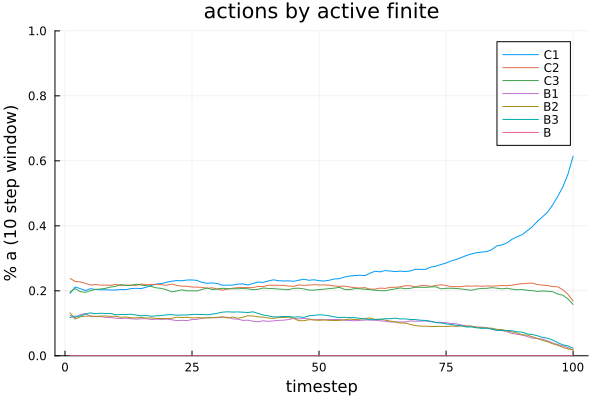

In [28]:
alg = afc
act = a_afc
Figs.plot_proportion_actions_all(act, actions, window, "actions by "*alg)

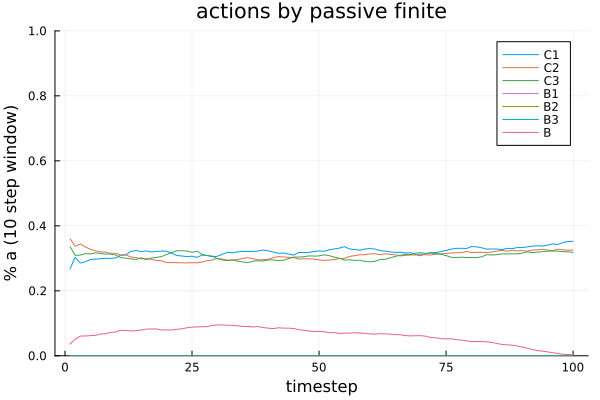

In [29]:
alg = pfc
act = a_pfc
Figs.plot_proportion_actions_all(act, actions, window, "actions by "*alg)

# LONG runs

**Parameters:**\
steps: 1000\
lookahead: 5\
runs: 20

_num items, arms, teachers: 3\
granularity of U and D: 3\
teacher betas: \[0.0, 0.01, 50.0\]\
state IDs: 1217, 1226, 1235, 1245, 4586, 4589, 4629, 4638, 4641, 1572, 1712, 3191, 3204, 3437, 3446, 3514, 3526, 3616, 4151, 4426_

**Algorithms:**\
ATS/active: select teachers and arms by solving POMDP\
passive: solve POMDP, but can't pick which teacher gets queried\
naive-X: act randomly for X steps, then always pull expected-best arm\
random: select teachers and arms randomly\
arms: pull arms randomly

**Variables:**\
discount: 0.9 (discounted) or 1.0 (undiscounted)\
horizon: finite or infinite\
rollout: random (all actions) or constrained (arm-only)

**Time:**\
active infinite: 2.5h\
passive infinite: 2.5h\
active finite: 3.5h\
passive finite: 3.5h\
random: 6m\
arms: 6m\
naive-50: 5m\
naive-100: 5m\
naive-200: 5m

In [87]:
# Experiment parameters
runs = 20
actions = ["C1", "C2", "C3", "B1", "B2", "B3", "B"]
afc, aic, pfc, pic = "active finite", "active infinite", "passive finite", "passive infinite"
r, ra, n50, n100, n200 = "random", "random arms", "naive-50", "naive-100", "naive-200"

# Plotting Parameters
labels = [afc aic pfc pic r ra n50 n100 n200]
discount = 0.999
window = 10
;

In [88]:
# Import experiments

# afc: active, finite, constrained
ids_afc = ["active_finite_23331_22581", "active_finite_23331_230912", "active_finite_23331_23194", "active_finite_23331_232832", "active_finite_23331_233745", "active_finite_23331_234620", "active_finite_23331_235559", "active_finite_2341_00042", "active_finite_2341_001352", "active_finite_2341_002354", "active_finite_2341_003143", "active_finite_2341_003937", "active_finite_2341_004937", "active_finite_2341_005730", "active_finite_2341_010754", "active_finite_2341_011826", "active_finite_2341_012934", "active_finite_2341_013739", "active_finite_2341_014528", "active_finite_2341_015325"]

# aic: active, infinite, constrained
ids_aic = ["active_infinite_23331_173929", "active_infinite_23331_174758", "active_infinite_23331_175550", "active_infinite_23331_180158", "active_infinite_23331_180838", "active_infinite_23331_18164", "active_infinite_23331_182331", "active_infinite_23331_183051", "active_infinite_23331_183832", "active_infinite_23331_18475", "active_infinite_23331_185539", "active_infinite_23331_190344", "active_infinite_23331_191151", "active_infinite_23331_19184", "active_infinite_23331_192554", "active_infinite_23331_194737", "active_infinite_23331_195422", "active_infinite_23331_200216", "active_infinite_23331_200820", "active_infinite_23331_201429"] 

# pfc: passive, finite, constrained
ids_pfc = ["passive_finite_2341_020331", "passive_finite_2341_021258", "passive_finite_2341_022038", "passive_finite_2341_022957", "passive_finite_2341_023919", "passive_finite_2341_024851", "passive_finite_2341_02583", "passive_finite_2341_030527", "passive_finite_2341_031352", "passive_finite_2341_032256", "passive_finite_2341_033150", "passive_finite_2341_034040", "passive_finite_2341_034844", "passive_finite_2341_03568", "passive_finite_2341_040431", "passive_finite_2341_041158", "passive_finite_2341_041938", "passive_finite_2341_042739", "passive_finite_2341_04373", "passive_finite_2341_044432"]

# pic: passive, infinite, constrained
ids_pic = ["passive_infinite_23331_202225", "passive_infinite_23331_202939", "passive_infinite_23331_203640", "passive_infinite_23331_204346", "passive_infinite_23331_20514", "passive_infinite_23331_205811", "passive_infinite_23331_21041", "passive_infinite_23331_211040", "passive_infinite_23331_211639", "passive_infinite_23331_21247", "passive_infinite_23331_212956", "passive_infinite_23331_213613", "passive_infinite_23331_214235", "passive_infinite_23331_215023", "passive_infinite_23331_215646", "passive_infinite_23331_220450", "passive_infinite_23331_221250", "passive_infinite_23331_222018", "passive_infinite_23331_222659", "passive_infinite_23331_223256"]

# r: random
ids_r = ["random_2343_12335", "random_2343_123324", "random_2343_123344", "random_2343_12345", "random_2343_123425", "random_2343_123444", "random_2343_12354", "random_2343_123524", "random_2343_123543", "random_2343_12364", "random_2343_123624", "random_2343_123645", "random_2343_12375", "random_2343_123724", "random_2343_123745", "random_2343_12385", "random_2343_123825", "random_2343_123845", "random_2343_12395", "random_2343_123925"]

# ra: random arms
ids_ra = ["arms_2343_12539", "arms_2343_125329", "arms_2343_125349", "arms_2343_12549", "arms_2343_125428", "arms_2343_125448", "arms_2343_12558", "arms_2343_125527", "arms_2343_125547", "arms_2343_12567", "arms_2343_125627", "arms_2343_125646", "arms_2343_12576", "arms_2343_125726", "arms_2343_125745", "arms_2343_12584", "arms_2343_125823", "arms_2343_125842", "arms_2343_12592", "arms_2343_125921"]

# n50: naive with explore_timesteps = 50
ids_n50 = ["naive_50_2347_121158", "naive_50_2347_121215", "naive_50_2347_121232", "naive_50_2347_121249", "naive_50_2347_12136", "naive_50_2347_121323", "naive_50_2347_121339", "naive_50_2347_121356", "naive_50_2347_121414", "naive_50_2347_121431", "naive_50_2347_121448", "naive_50_2347_12155", "naive_50_2347_121523", "naive_50_2347_121540", "naive_50_2347_121557", "naive_50_2347_121614", "naive_50_2347_121631", "naive_50_2347_121648", "naive_50_2347_12175", "naive_50_2347_121722"]

# n100: naive with explore_timesteps = 100
ids_n100 = ["naive_100_2347_121858", "naive_100_2347_121914", "naive_100_2347_121931", "naive_100_2347_121948", "naive_100_2347_12205", "naive_100_2347_122022", "naive_100_2347_122039", "naive_100_2347_122056", "naive_100_2347_122112", "naive_100_2347_122129", "naive_100_2347_122146", "naive_100_2347_12222", "naive_100_2347_122219", "naive_100_2347_122236", "naive_100_2347_122253", "naive_100_2347_12239", "naive_100_2347_122326", "naive_100_2347_122343", "naive_100_2347_12240", "naive_100_2347_122417"]

# n200: naive with explore_timesteps = 200
ids_n200 = ["naive_200_2347_122512", "naive_200_2347_122528", "naive_200_2347_122545", "naive_200_2347_12261", "naive_200_2347_122617", "naive_200_2347_122634", "naive_200_2347_122650", "naive_200_2347_12276", "naive_200_2347_122723", "naive_200_2347_122739", "naive_200_2347_122756", "naive_200_2347_122812", "naive_200_2347_122828", "naive_200_2347_122845", "naive_200_2347_12291", "naive_200_2347_122918", "naive_200_2347_122934", "naive_200_2347_122950", "naive_200_2347_12307", "naive_200_2347_123023"]

s_afc, t_afc, a_afc, r_afc = Import.import_IDs(ids_afc, runs, directory="..")
s_aic, t_aic, a_aic, r_aic = Import.import_IDs(ids_aic, runs, directory="..")
s_pfc, t_pfc, a_pfc, r_pfc = Import.import_IDs(ids_pfc, runs, directory="..")
s_pic, t_pic, a_pic, r_pic = Import.import_IDs(ids_pic, runs, directory="..")
s_r, t_r, a_r, r_r = Import.import_IDs(ids_r, runs, directory="..")
s_ra, t_ra, a_ra, r_ra = Import.import_IDs(ids_ra, runs, directory="..")
s_n50, t_n50, a_n50, r_n50 = Import.import_IDs(ids_n50, runs, directory="..")
s_n100, t_n100, a_n100, r_n100 = Import.import_IDs(ids_n100, runs, directory="..")
s_n200, t_n200, a_n200, r_n200 = Import.import_IDs(ids_n200, runs, directory="..")
;

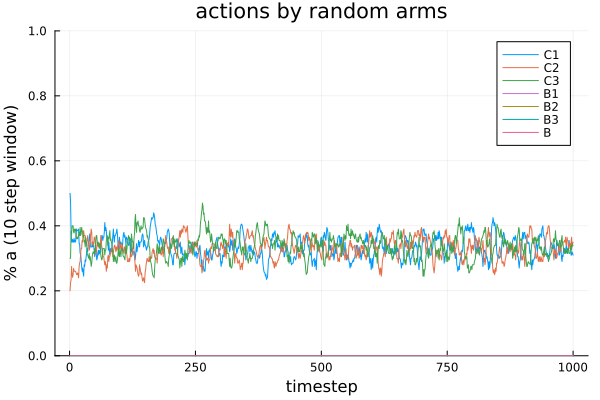

In [89]:
alg = ra
act = a_ra
Figs.plot_proportion_actions_all(act, actions, window, "actions by "*alg)

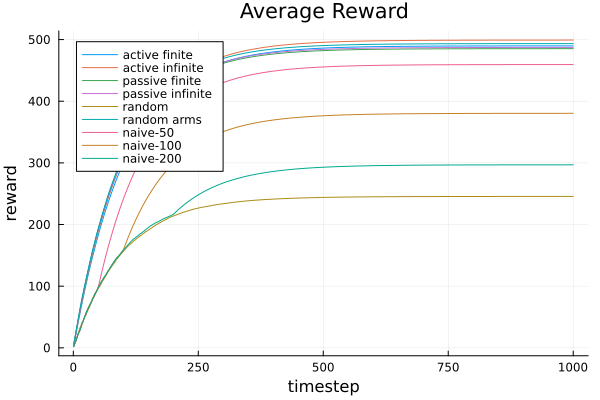

In [93]:
Figs.plot_cumulative_avg_r_multiple_experiments([r_afc, r_aic, r_pfc, r_pic, r_r, r_ra, r_n50, r_n100, r_n200], 0.99, labels, "Average Reward")

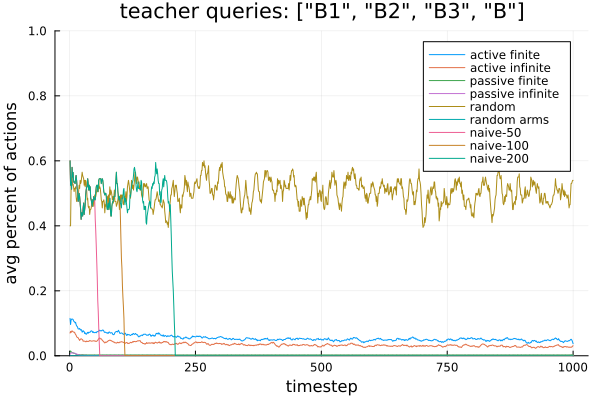

In [96]:
Figs.plot_actions_in_list_rolling_multiple_experiments([a_afc, a_aic, a_pfc, a_pic, a_r, a_ra, a_n50, a_n100, a_n200], ["B1", "B2", "B3", "B"], window, labels, "teacher queries: ")

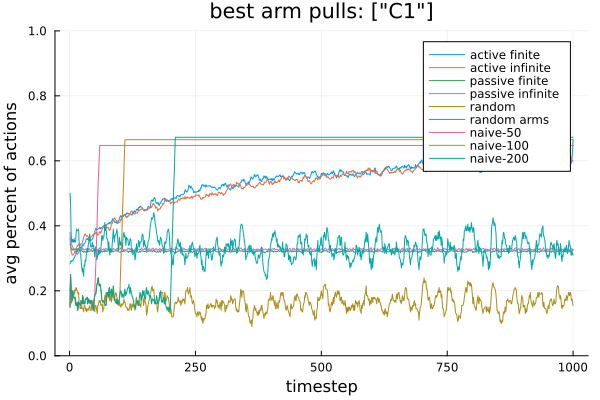

In [97]:
Figs.plot_actions_in_list_rolling_multiple_experiments([a_afc, a_aic, a_pfc, a_pic, a_r, a_ra, a_n50, a_n100, a_n200], ["C1"], window, labels, "best arm pulls: ")

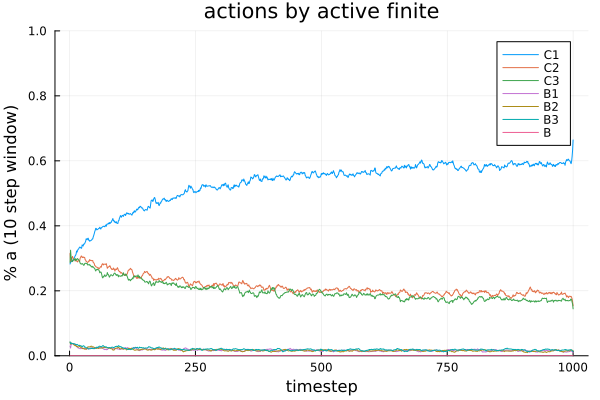

In [52]:
alg = afc
act = a_afc
Figs.plot_proportion_actions_all(act, actions, window, "actions by "*alg)

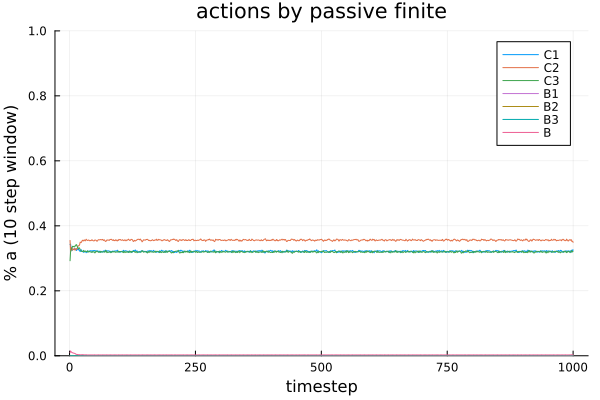

In [53]:
alg = pfc
act = a_pfc
Figs.plot_proportion_actions_all(act, actions, window, "actions by "*alg)